In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

import tensorflow.keras.backend as K
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from numpy.random import seed

!pip install -q seaborn
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
from utils import DataLoader
from encoders import KMerEncoder, OneHotEncoder

In [3]:
# encoder = OneHotEncoder(2, 200, 'random')
encoder = KMerEncoder(1, 200, 'random')

In [4]:
dataloader = DataLoader(
        '../datasets/x_train.fasta', 
        '../datasets/x_val.fasta', 
        '../datasets/x_test.fasta', default_noise = 25)

In [5]:
train_seq, train_labels = dataloader.generate_training_data()
test_seq, test_labels = dataloader.generate_testing_data()
val_seq, val_labels = dataloader.generate_validation_data()

In [6]:
le = preprocessing.LabelEncoder()
le.fit(train_labels)
num_classes = len(np.unique(train_labels))

train_labels_num = le.transform(train_labels)
val_labels_num = le.transform(val_labels)
test_labels_num = le.transform(test_labels)

train_labels_bin = keras.utils.to_categorical(train_labels_num, num_classes)
val_labels_bin = keras.utils.to_categorical(val_labels_num, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels_num, num_classes)

In [73]:
y_true = np.argmax(test_labels_bin, axis=1)
y_true = le.inverse_transform(y_true)
labels,lcounts = np.unique(y_true,return_counts=True)

In [95]:
train_seq = list(map(encoder.encode, train_seq))
test_seq = list(map(encoder.encode, test_seq))
val_seq = list(map(encoder.encode, val_seq))

train_seq = keras.utils.to_categorical(train_seq)
val_seq = keras.utils.to_categorical(val_seq)
test_seq = keras.utils.to_categorical(test_seq)

In [100]:
from models import buildCNNModel

tf.keras.backend.clear_session()

batch_size = 32
nlayers = 3
learning_rate = 0.001
epochs = 10

m = buildCNNModel(inshape=train_seq.shape[1:], num_classes=num_classes, nlayers=nlayers, cnndim=1)
                
m.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# m.fit(train_seq, 
#     train_labels_bin,
#     verbose = 1,
#     batch_size = batch_size,
#     shuffle = True,
#     epochs = epochs,
#     validation_data = (val_seq, val_labels_bin))

In [206]:
pred = m.predict(test_seq, verbose=1)
predicted = np.argmax(pred, axis=1)
y_pred = le.inverse_transform(predicted)

17324/17324 [==============================] - 1s 40us/sample


In [207]:
matthews_corrcoef(y_true, y_pred)

0.8360206396242124

In [208]:
from encoders import RandomEncoder

In [209]:
random_encoder = RandomEncoder('../datasets/x_test.fasta')

In [210]:
randoms = random_encoder.encode(2, 1) + random_encoder.encode(3, 1) + random_encoder.encode(6, 1) + random_encoder.encode(12, 1)
randoms = list(map(encoder.encode, randoms))
randoms = keras.utils.to_categorical(randoms)

In [211]:
len(test_seq), len(randoms)

(17324, 101368)

In [212]:
mc = 100

model_mc = K.function([m.input, K.learning_phase()], [m.output])

test_seq_rnd = randoms

avrp_rnd = np.zeros((len(test_seq_rnd),num_classes))
avrp_nornd = np.zeros((len(test_seq),num_classes))

fp_rnd = np.zeros((len(test_seq_rnd),num_classes))
fp_nornd = np.zeros((len(test_seq),num_classes))

avrhp_rnd = np.zeros((len(test_seq_rnd)))
avrhp_nornd = np.zeros((len(test_seq)))

p_rnd = np.zeros((mc,len(test_seq_rnd),num_classes))
p_nornd = np.zeros((mc,len(test_seq),num_classes))

for i in tqdm(range(mc)):
    preds_nornd=model_mc([test_seq,1])
    p_nornd[i,:,:] = preds_nornd[0]
    avrp_nornd = avrp_nornd + preds_nornd[0]
    avrhp_nornd = avrhp_nornd + np.sum(-preds_nornd[0]*np.log2(preds_nornd[0]+1e-10),1)
    midx = np.argmax(preds_nornd[0],1)
    for j in range(len(test_seq)):
        fp_nornd[j,midx[j]] = fp_nornd[j,midx[j]] + 1

    preds_rnd=model_mc([test_seq_rnd,1])
    p_rnd[i,:,:] = preds_rnd[0]
    avrp_rnd = avrp_rnd + preds_rnd[0]
    avrhp_rnd = avrhp_rnd + np.sum(-preds_rnd[0]*np.log2(preds_rnd[0]+1e-10),1)
    midx = np.argmax(preds_rnd[0],1)
    for j in range(len(test_seq_rnd)):
        fp_rnd[j,midx[j]] = fp_rnd[j,midx[j]] + 1


avrp_rnd = avrp_rnd/mc
avrp_nornd = avrp_nornd/mc
fp_rnd = fp_rnd/mc
fp_nornd = fp_nornd/mc
avrhp_rnd = avrhp_rnd/mc
avrhp_nornd = avrhp_nornd/mc

    # compute indicators entropy (hp) variance (var) max prob (maxp) and f max

hp_nornd = np.sum(-avrp_nornd*np.log2(avrp_nornd+1e-10),1)
hp_rnd = np.sum(-avrp_rnd*np.log2(avrp_rnd+1e-10),1)

var_rnd = np.var(p_rnd,0)
var_nornd = np.var(p_nornd,0)

orderp_rnd = np.argsort(-avrp_rnd,1)
orderp_nornd = np.argsort(-avrp_nornd,1)

maxp_nornd = np.max(avrp_nornd,1)
maxp_rnd = np.max(avrp_rnd,1)
maxfp_nornd = np.max(fp_nornd,1)
maxfp_rnd = np.max(fp_rnd,1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [54]:
figure(figsize=(9, 5), dpi=180)

with plt.xkcd():
    sns.kdeplot(hp_rnd, shade=True, label='random seq')
    sns.kdeplot(hp_nornd, shade=True, label='ncRNA seq')

    plt.title('Information Entropy\n' + r'H = -$\Sigma p_{k} log_{2} (p_k + \epsilon)$', size=20)
    plt.legend()
    plt.show()

NameError: name 'figure' is not defined

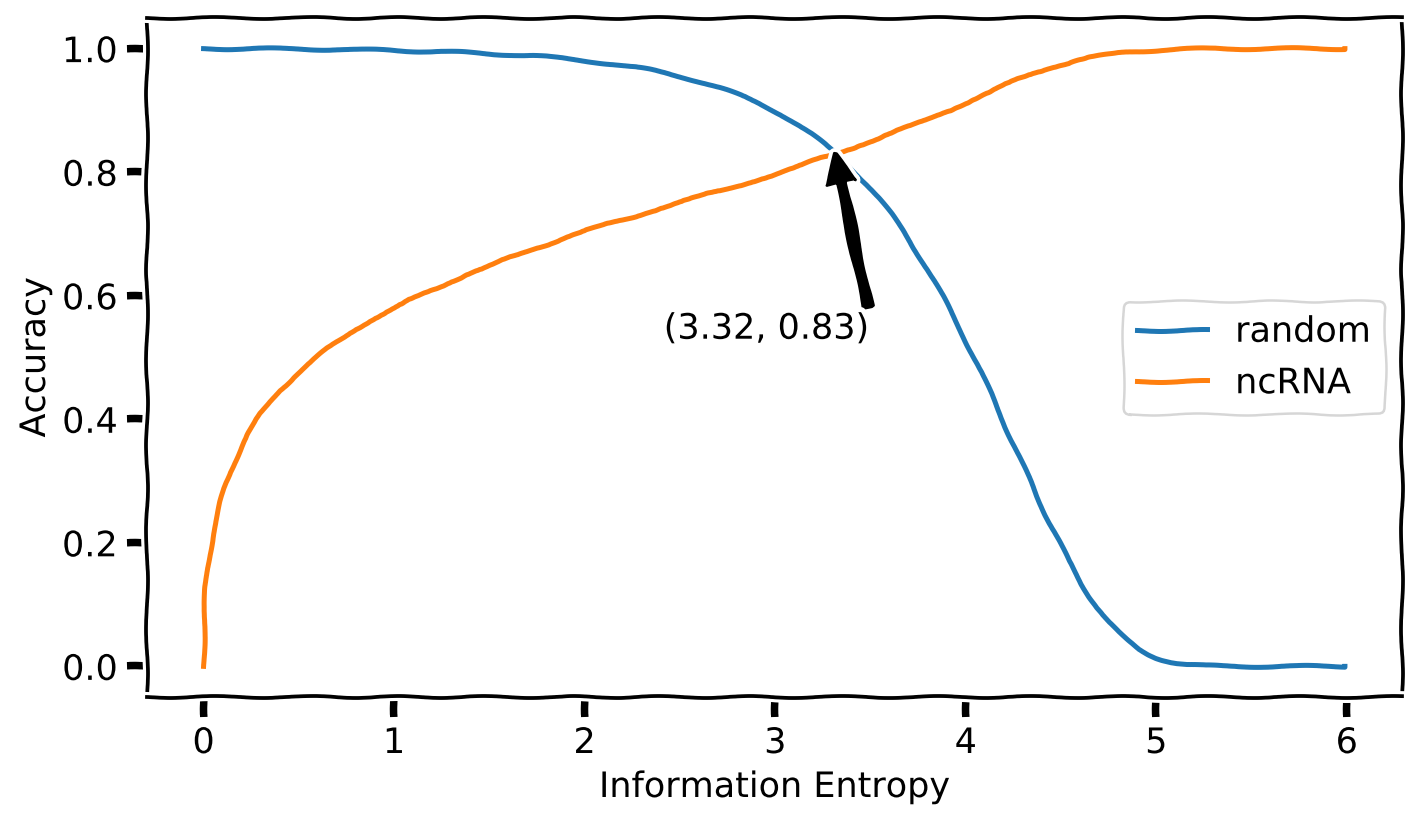

In [215]:
figure(figsize=(9, 5), dpi=180)

def acc(T):
    return np.where(hp_rnd > T)[0].__len__() / len(hp_rnd), np.where(hp_nornd <= T)[0].__len__() / len(hp_nornd)

x = np.arange(0, 6, 0.01)
ys = np.array([acc(i) for i in x])
yr = ys[:,0]
yn = ys[:,1]

idx = [np.where(np.round(yr, 2) == np.round(yn, 2))[0]]
a, b = np.mean(x[idx]), np.mean(yr[idx])

with plt.xkcd():
    plt.annotate(xytext = (a-0.9, b-0.3), xy = (a, b), 
                 arrowprops={'facecolor': 'black'}, s=f'{np.round(a, 2), np.round(b, 2)}')
    plt.plot(x, yr, label = 'random')
    plt.plot(x, yn, label = 'ncRNA')
    plt.ylabel('Accuracy')
    plt.xlabel('Information Entropy')
    plt.legend()
    plt.show()

In [216]:
class EntropyClassifier:
    def __init__(self, model, encoder, classes, threshold):
        self.T = threshold
        self.model = model
        self.encoder = encoder
        self.classes = classes
        
        
    def _calculate_entropy(self, test_seqs, iterations):
        avrp_rnd = np.zeros((len(test_seqs), len(self.classes)))
        avrhp_rnd = np.zeros((len(test_seqs)))
        
        for _ in range(iterations):
            preds_rnd = self.model([test_seqs,1])
            avrp_rnd = avrp_rnd + preds_rnd[0]
            avrhp_rnd = avrhp_rnd + np.sum(-preds_rnd[0]*np.log2(preds_rnd[0]+1e-10),1)
            
        avrp_rnd = avrp_rnd/iterations
        avrhp_rnd = avrhp_rnd/iterations
        hp_rnd = np.sum(-avrp_rnd*np.log2(avrp_rnd+1e-10),1)
        
        return hp_rnd
    
    def predict(self, test_seqs):
        entropies = self._calculate_entropy(test_seqs, iterations=50)
        
        
        return np.where(entropies > self.T, 0, 1)

In [218]:
clf = EntropyClassifier(model = model_mc, encoder=None, classes=np.unique(train_labels), threshold=a)

In [219]:
test_seq_rnd2 = test_seq_rnd[np.random.randint(0, len(test_seq_rnd), len(test_seq))]

In [220]:
len(test_seq_rnd2), len(test_seq)

(17324, 17324)

In [221]:
%%time

p_random = clf.predict(test_seq_rnd2)
p_reals = clf.predict(test_seq)

CPU times: user 11.1 s, sys: 6.78 s, total: 17.9 s
Wall time: 16.9 s


In [222]:
y_preds = np.hstack([p_random, p_reals])
y_true = np.hstack([np.zeros(len(p_random)), np.ones(len(p_reals))])

In [223]:
accuracy_score(y_true, y_preds)

0.8201339182636804